## Упражнение на свертку

*Раед Романов*


### Свернем кота
### Грузим картинку котэ

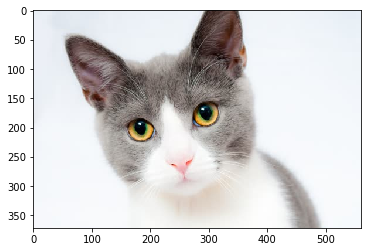

In [66]:
import torch
import torchvision as tv
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
cat_convolve= Image.open('./imgs/cat_convolve.jpg')
plt.imshow(cat_convolve)

### Превращаем кота в тензор

In [67]:
cat_tensor = tv.transforms.ToTensor()(cat_convolve)
# cat_tensor.unsqueeze_(0)
print (cat_tensor.size())

torch.Size([3, 372, 560])


### Создаем фильтр ядра и заполняем его -1 & 8

In [68]:
filter_kernel = torch.FloatTensor(3, 3, 3).fill_(-1)
filter_kernel[:, 1, 1] = 8
print(filter_kernel.size())

torch.Size([3, 3, 3])


## Моя собственная свертка

In [113]:
def my_conv2d(inp, kernel, stride=(1,1), padding=0):
    flag = 0
    if isinstance(stride, int):
        stride = (stride, stride)
    newW = (inp.shape[1] - kernel.shape[1] + padding * 2) // stride[0] + 1
    newH = (inp.shape[2] - kernel.shape[2] + padding * 2) // stride[1] + 1
    outp = torch.FloatTensor(torch.Size([newW, newH]))
        
    ker_l = 0
    ker_r = kernel.shape[1]
    ker_u = 0
    ker_d = kernel.shape[2]
    
    inp_l = - padding
    inp_r = inp_l + kernel.shape[1]
    
    for i in range(newW):
        inp_u = - padding 
        inp_d = inp_u + kernel.shape[2]
        ker_l = 0 if inp_l > 0 else -inp_l
        ker_r = min(kernel.shape[1],ker_l-max(0,inp_l)+min(inp_r,inp.shape[1]))
        for j in range(newH):
            if((-max(0,inp_l)+min(inp_r,inp.shape[1]) > 0) and 
                (-max(0,inp_u)+min(inp_d,inp.shape[2]) > 0)):
                ker_u = 0 if inp_u > 0 else -inp_u
                ker_d = min(kernel.shape[2],ker_u-max(0,inp_u)+min(inp_d,inp.shape[2]))        
                outp[i,j] = torch.mul(inp[:, max(0,inp_l):min(inp_r,inp.shape[1]), 
                                     max(0,inp_u):min(inp_d,inp.shape[2])],
                              kernel[:, ker_l:ker_r,ker_u:ker_d]).sum()
                 
            inp_u += stride[1]
            inp_d += stride[1]
            
        inp_l += stride[0]
        inp_r += stride[0]
        
    return outp


### Делаем свертку картинки ядром

torch.Size([374, 562])


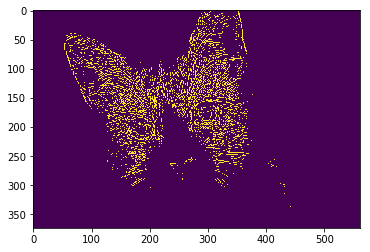

In [114]:
o_image = my_conv2d(cat_tensor, filter_kernel, 1, 2)
o_image[o_image >= 0.5] = 1.0  # бустим границы
o_image[o_image < 0.99] = 0

print(o_image.size())
plt.imshow(o_image.numpy())

### Что будет с картинкой, если мы возьмем ядро  $ \begin{bmatrix}
    1 & 1 \\
    1 & 1
\end{bmatrix}$ и пройдем картинку конволюцией с шагом(stride)=2?


torch.Size([186, 280])


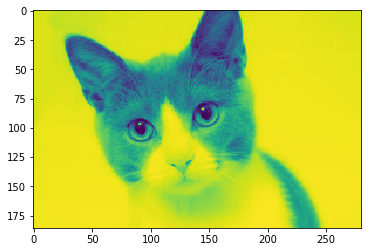

In [115]:
filter_kernelx2 = torch.FloatTensor(3, 2, 2).fill_(1)
o_image = my_conv2d(cat_tensor, filter_kernelx2, stride=(2,2))
o_image /= 4 # усредняем

print(o_image.size())
plt.imshow(o_image.numpy())

# Ядро свертки с гаусовым распределением

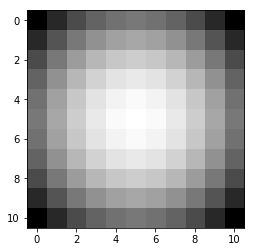

In [116]:
import scipy.ndimage as ndi
import numpy as np
sigma = 10    # параметр распределение
patern_size = 101 # максимальный размер ядра свертки
kernel_size = 10  # реальный размер свертки
x = np.zeros((patern_size, patern_size))
x [patern_size//2, patern_size//2] = 1

# делаем ядро с гаусовым распределением
gause_kernel = ndi.filters.gaussian_filter(x, sigma=sigma)
# вырезаем из центра наш кернел
gause_kernel = gause_kernel[(patern_size//2-(kernel_size//2)):(patern_size//2+(kernel_size//2))+1, \
                (patern_size//2-(kernel_size//2)):(patern_size//2+(kernel_size//2))+1]
# вот он
plt.imshow(gause_kernel, interpolation='none', cmap=plt.get_cmap('gray'))

### Делаем свертку

torch.Size([362, 550])


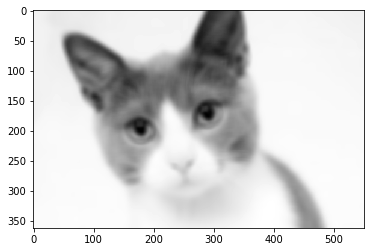

In [117]:
o_image = my_conv2d(cat_tensor, torch.from_numpy(gause_kernel).float().unsqueeze(0))

print(o_image.size())
plt.imshow(o_image.numpy(), cmap='gray')